In [1]:
# Import useful modules:
import numpy as np
from matplotlib import pyplot as plt
# from IPython.display import Audio
import scipy.signal as sg
import scipy.io
import librosa

In [2]:
# Functions to compute the target activity
def tkeo(x):
    m=1
    M=1
    y = np.zeros_like(x)
    for n in range(M,len(x)-M):
        y[n] = x[n]**(2/m) - (x[int(n-M)]*x[int(n+M)])**(1/m)
        # y[n] = x[n]*x[n+m-2]-x[n-1]*x[n+m-1]
    return y

def activity(x):
    y = np.abs(tkeo(x))
    y = y/np.max(y)
    y[y>np.quantile(y,0.9)] = 1
    y[y<=np.quantile(y,0.9)] = 0
    # y[y>np.std(y)] = 1
    # y[y<=np.std(y)] = 0
    y = y.astype(bool)
    return y    

# Spectral Kurtosis
def spectral_kurt(X):
    eps=1e-15
    bar_X = np.mean(X,axis=0)
    diff = X-bar_X
    numerator = np.mean(diff**4,axis=0)
    denominator= np.mean(diff**2,axis=0)**2
    kurtX = numerator/(denominator+eps)
    return kurtX    

# (2) Musical Noise measurement: Perceptually Improved Log-Kurtosis Ratio
def compute_Xplus(x,fs,pthr=0.05):
    eps = 1e-15
    wl = 1024
    stft = librosa.stft(x, window='cosine', n_fft=2*wl, win_length=wl, hop_length=wl//2)
    X_dBA = np.abs(stft)**2
    f = np.linspace(0,fs/2,X_dBA.shape[0])

    # Get the dBA
    Aw = 10**(librosa.A_weighting(f)/10)

    for col in range(X_dBA.shape[1]):
        X_dBA[:,col] = X_dBA[:,col] * Aw
    
    PdBA = 10*np.log10(np.mean(np.mean(X_dBA,axis=0))+eps)
    X_dBA = 10*np.log10(X_dBA+eps)    

    thr = PdBA-20
    Xplus = X_dBA-thr
    Xplus[Xplus<0] = 0

    # Check frames where the energy is 0 for all frequencies to remove them later.
    ind_frames = np.sum(Xplus, axis=0) > 0
    
    # Get sub-bands:
    Xplus_subb = list()

    # Band 1: Between 50Hz and 750Hz
    fb1 = np.logical_and(f > 50, f <= 750)
    Xplus_subb.append(Xplus[fb1,:])

    # Band 2: Between 50Hz and 750Hz
    fb2 = np.logical_and(f > 750, f <= 6000)
    Xplus_subb.append(Xplus[fb2,:])

    # Band 3: Between 50Hz and 750Hz
    fb3 = np.logical_and(f > 6000, f <= np.min([f[-1],16000]))
    Xplus_subb.append(Xplus[fb3,:])

    return Xplus_subb, ind_frames

def perceptual_kurt_ratio(xi,xo,fs,act=None):
    # Resample and normalize signals:
    xi_rs = sg.resample(xi,int(len(xi)*48000/fs))
    xo_rs = sg.resample(xo,int(len(xo)*48000/fs))
    xo_rs = xo_rs / np.max(np.abs(xo_rs))
    xi_rs = xi_rs / np.max(np.abs(xi_rs))

    # Only consider the segments where the target is not active.
    xi_rs = xi_rs*act
    xo_rs = xo_rs*act
    xi_rs = xi_rs[act>0]
    xo_rs = xo_rs[act>0]

    # Compute X^{+} for three frequency bands.
    Xplus_subb_i,idx_i = compute_Xplus(xi_rs,48000)
    Xplus_subb_o,idx_o = compute_Xplus(xo_rs,48000)

    # Remove frames where the energy is null.
    idx = np.logical_and(idx_i,idx_o)
    Xplus_subb_i = [X[:,idx_i] for X in Xplus_subb_i]
    Xplus_subb_o = [X[:,idx_i] for X in Xplus_subb_o]
    
    # Compute Spectral Weights for each band
    wo = [10*np.log10(np.mean(10**(X/10),axis=0)) for X in Xplus_subb_o]

    # Compute Spectral Kurtosis of the subbands
    kurt_subb_i = [spectral_kurt(X) for X in Xplus_subb_i]
    kurt_subb_o = [spectral_kurt(X) for X in Xplus_subb_o]

    # Compute the spectral log-kurtosis ratios for each band
    eps = 1e-15
    DeltaK_B = []
    for i in range(len(kurt_subb_o)):
        cociente = kurt_subb_o[i]/(kurt_subb_i[i]+eps)
        temp = np.abs(np.log(cociente+eps))
        DeltaK_B.append(temp)

    # Compute Delta Kurt_PI for each band, select the maximum and normalize.
    DeltaK_PI_aux = [np.sum(w*DeltaK)/(np.sum(w)+eps) for w, DeltaK in zip(wo,DeltaK_B)]
    band_index = np.nanargmax(DeltaK_PI_aux)
    lb = 0.5
    DeltaK_B = np.min([DeltaK_PI_aux[band_index],lb])
    DeltaK_PI = 100*(1-DeltaK_B/lb)
    return DeltaK_PI 

In [3]:
# Import the files from the PEASS dataset and apply the measure.
from scipy.io import wavfile
DKPI = np.zeros((6,4))
for k,file_num in enumerate([3,5,6,7,8,9]):
    
    #Import the target signal.
    filename = 'exp0{}_target.wav'.format(file_num)
    fs, x_target = wavfile.read(filename)  
    x_target = x_target[:,0]/np.max(np.abs(x_target[:,0]))
    x_target = sg.resample_poly(x_target,48000,fs)
    x_target = x_target / np.max(np.abs(x_target))

    # Compute the target activity
    act = activity(x_target)
    act = np.invert(act)

    # exp0{}_input.wav has all the influences summed to the target.
    filename = 'exp0{}_input.wav'.format(file_num)
    fs, xi = wavfile.read(filename)
    xi = xi[:,0]/np.max(np.abs(xi[:,0]))
    xi = sg.resample(xi,int(len(xi)*48000/fs)) 
    xi = xi / np.max(np.abs(xi))

    for j in range(4):
        filename = 'exp0{}_test{}.wav'.format(file_num,j+5)
        fs, xo = wavfile.read(filename)  
        xo = xo[:,0]/np.max(np.abs(xo[:,0]))
        xo = sg.resample_poly(xo,48000,fs)
        xo = xo / np.max(np.abs(xo))
    
        DKPI[k,j] = perceptual_kurt_ratio(xi,xo,act=act,fs=48000)

c:\Users\juan_\Nextcloud\Miramont_Juan\python_code\benchmark-mn\.venv\lib\site-packages\librosa\core\convert.py:1332: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


In [4]:
# Import a .mat file from Matlab where I saved the APS values and the subjective scores.
data_peass = scipy.io.loadmat('data_peass.mat')
APS = data_peass['APS']
scores_AIA = data_peass['scores_AIA']
a = np.resize(DKPI,(DKPI.size,))
b = np.resize(APS,(APS.size,))
c = np.corrcoef(a,b)

0.7678125065752976


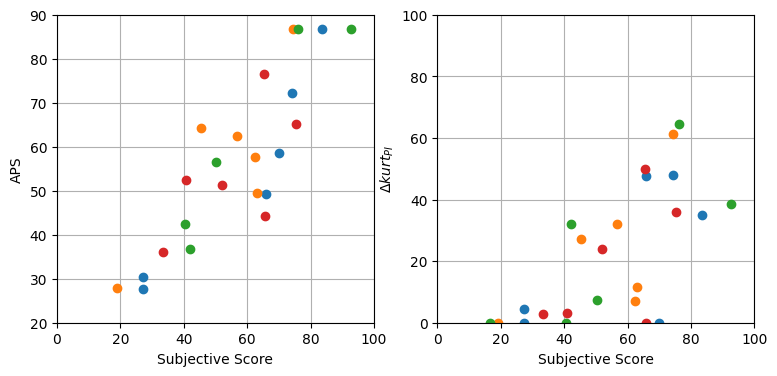

In [5]:
# Plot everything
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1,2,figsize=(9,4))
for i in range(4):
    axs[0].plot(scores_AIA[:,i],APS[:,i],'o')
axs[0].set_xlim([0,100])
axs[0].set_ylim([20,90])
axs[0].set_xlabel('Subjective Score')
axs[0].set_ylabel('APS')
axs[0].grid(True)
for i in range(4):
    axs[1].plot(scores_AIA[:,i],DKPI[:,i],'o')
axs[1].set_xlim([0,100])
axs[1].set_ylim([0,100])
axs[1].set_xlabel('Subjective Score')
axs[1].set_ylabel(r'$\Delta kurt_{PI}$')
axs[1].grid(True)
print(c[0,1])
plt.show()
